In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers

from PIL import Image

In [2]:
# type: ignore
def resnet_feature_extractor(input_shape):
    base_model = tf.keras.applications.ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freezing the base model for efficiency
    x = layers.GlobalAveragePooling2D()(base_model.output)
    return models.Model(inputs=base_model.input, outputs=x)

In [3]:
# type: ignore
def lstm_temporal_analysis(x, lstm_units=64):
    # Reshape to make sure it's in the right shape for LSTM
    x = layers.Reshape((-1, x.shape[-1]))(x)
    
    # LSTM for detecting temporal patterns
    x = layers.LSTM(lstm_units, return_sequences=True)(x)
    x = layers.LSTM(lstm_units, return_sequences=True)(x)
    
    # Self-Attention to capture repetitive patterns
    attention = layers.MultiHeadAttention(num_heads=4, key_dim=lstm_units)(x, x)
    x = layers.Add()([x, attention])
    x = layers.GlobalAveragePooling1D()(x)
    
    return x



In [4]:
# type: ignore
def tiny_transformer_block(x, d_model, num_heads, dff, training):
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    attn_output = layers.Dropout(0.1)(attn_output, training=training)
    out1 = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)

    ffn_output = layers.Dense(dff, activation='relu')(out1)
    ffn_output = layers.Dense(d_model)(ffn_output)
    ffn_output = layers.Dropout(0.1)(ffn_output, training=training)

    return layers.LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

def ensemble_adapters(x, num_adapters, d_model, bottleneck_dim):
    adapter_outputs = []
    for _ in range(num_adapters):
        adapter = layers.Dense(bottleneck_dim, activation='gelu')(x)
        adapter = layers.Dense(d_model)(adapter)
        adapter_outputs.append(adapter)

    adapter_outputs = tf.stack(adapter_outputs, axis=0)
    adapter_outputs = tf.reduce_mean(adapter_outputs, axis=0)
    
    return x + adapter_outputs

def feature_wise_transformation(x, d_model):
    scale = tf.Variable(initial_value=tf.ones((d_model,)), trainable=True)
    shift = tf.Variable(initial_value=tf.zeros((d_model,)), trainable=True)
    return x * scale + shift

def adaptive_transformer_block(x, d_model, num_heads, dff, num_adapters, bottleneck_dim, training):
    x = tiny_transformer_block(x, d_model, num_heads, dff, training)
    x = ensemble_adapters(x, num_adapters, d_model, bottleneck_dim)
    return feature_wise_transformation(x, d_model)


In [5]:
def class_conditional_domain_discriminator(x, num_domains, d_model):
    x = layers.Dense(d_model, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    domain_pred = layers.Dense(num_domains, activation='softmax', name='domain_output')(x)
    return domain_pred


In [6]:
from tensorflow.keras.layers import Layer
# def build_combined_model(input_shape, d_model=64, num_heads=4, dff=128, num_blocks=4, num_adapters=2, bottleneck_dim=32, lstm_units=64, num_domains=2):
#     inputs = layers.Input(shape=input_shape)

#     # ResNet Feature Extraction
#     resnet_model = resnet_feature_extractor(input_shape=input_shape)
#     x = resnet_model(inputs)

#     # LSTM for Temporal Analysis and Repetitive Pattern Detection
#     x = lstm_temporal_analysis(x, lstm_units=lstm_units)

#     # Reshape for Transformer input
#     x = layers.Reshape((1, -1))(x)  # Adjust based on expected transformer input

#     # Adaptive Transformer Blocks
#     for _ in range(num_blocks):
#         x = adaptive_transformer_block(x, d_model, num_heads, dff, num_adapters, bottleneck_dim, training=True)

#     # Global Pooling and Feature Extraction
#     x = layers.GlobalAveragePooling1D()(x)

#     # Class-Conditional Domain Discriminator
#     domain_pred = class_conditional_domain_discriminator(x, num_domains, d_model)
    
#     # Final Classification (Real vs Spoof)
#     spoof_pred = layers.Dense(1, activation='sigmoid', name='spoof_output')(x)

#     model = models.Model(inputs=inputs, outputs=[spoof_pred, domain_pred])
#     return model
# Debugging the adaptive_transformer_block function
# def adaptive_transformer_block(x, d_model, num_heads, dff, num_adapters, bottleneck_dim, training):
#     print(f"Input shape to transformer block: {x.shape}")
#     x = tiny_transformer_block(x, d_model, num_heads, dff, training)
#     print(f"Shape after transformer block: {x.shape}")
    
#     # Temporarily simplifying ensemble_adapters for debugging
#     try:
#         x = ensemble_adapters(x, num_adapters, d_model, bottleneck_dim)
#     except Exception as e:
#         print(f"Error in ensemble_adapters: {e}")
#         raise
    
#     print(f"Shape after ensemble_adapters: {x.shape}")
#     return x

class EnsembleAdaptersLayer(Layer):
    def __init__(self, num_adapters, d_model, bottleneck_dim):
        super(EnsembleAdaptersLayer, self).__init__()
        self.num_adapters = num_adapters
        self.d_model = d_model
        self.bottleneck_dim = bottleneck_dim

    def call(self, x):
        return x

def adaptive_transformer_block(x, d_model, num_heads, dff, num_adapters, bottleneck_dim, training):
    x = tiny_transformer_block(x, d_model, num_heads, dff, training)
    
    # Use the custom layer instead of a direct function call
    x = EnsembleAdaptersLayer(num_adapters, d_model, bottleneck_dim)(x)
    
    return x


def build_combined_model(input_shape, d_model=64, num_heads=4, dff=128, num_blocks=4, num_adapters=2, bottleneck_dim=32, lstm_units=64, num_domains=2):
    inputs = layers.Input(shape=input_shape)

    # ResNet Feature Extraction
    resnet_model = resnet_feature_extractor(input_shape=input_shape)
    x = resnet_model(inputs)

    # LSTM for Temporal Analysis and Repetitive Pattern Detection
    x = lstm_temporal_analysis(x, lstm_units=lstm_units)

    # Reshape for Transformer input
    x = layers.Reshape((1, -1))(x)  # Adjust based on expected transformer input

    # Adaptive Transformer Blocks
    for i in range(num_blocks):
        print(f"Processing block {i+1}/{num_blocks}")
        x = adaptive_transformer_block(x, d_model, num_heads, dff, num_adapters, bottleneck_dim, training=True)

    # Global Pooling and Feature Extraction
    x = layers.GlobalAveragePooling1D()(x)

    # Class-Conditional Domain Discriminator
    domain_pred = class_conditional_domain_discriminator(x, num_domains, d_model)
    
    # Final Classification (Real vs Spoof)
    spoof_pred = tf.keras.layers.Dense(1, activation='sigmoid', name='spoof_output')(x)



    model = models.Model(inputs=inputs, outputs=[spoof_pred, domain_pred])
    return model

# Attempt to build and summarize the model
try:
    model = build_combined_model(input_shape=(224, 224, 3))
    model.summary()
except Exception as e:
    print(f"Model build failed: {e}")



Processing block 1/4
Processing block 2/4
Processing block 3/4
Processing block 4/4
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 2048)         23587712    ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 1, 2048)      0           ['model[0][0]']                  
                                                                                                  
 lstm (L

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    r"C:\Users\Kavyansh Tyagi\OneDrive\Desktop\programming\advanced computer vision\SIH2024\d1\train_img\train_img",
    target_size=(224, 224),  
    batch_size=16,
    class_mode='binary', 
    color_mode='rgb', 
)

test_generator = test_datagen.flow_from_directory(
    r"C:\Users\Kavyansh Tyagi\OneDrive\Desktop\programming\advanced computer vision\SIH2024\d1\test_img\test_img",
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary', 
    color_mode='rgb',
)

# Build and check model
model = build_combined_model(input_shape=(224, 224, 3))

# Check if model creation was successful
if model is not None:
    print("Model built successfully.")
else:
    print("Model building failed.")

# Print model summary
try:
    model.summary()
except Exception as e:
    print(f"Error in printing model summary: {e}")

# Compile the model
model.compile(
    optimizer='adam',
    loss={'spoof_output': 'binary_crossentropy', 'domain_output': 'binary_crossentropy'},
    metrics={'spoof_output': 'accuracy', 'domain_output': 'accuracy'}
)



Found 3310 images belonging to 2 classes.
Found 4816 images belonging to 2 classes.
Processing block 1/4
Processing block 2/4
Processing block 3/4
Processing block 4/4
Model built successfully.
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_2 (Functional)           (None, 2048)         23587712    ['input_3[0][0]']                
                                                                                                  
 reshape_2 (Reshape)            (None, 1, 2048)      0           ['model_2[0][0]']              

In [9]:
# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=40
)


Epoch 1/40


TypeError: 'NoneType' object is not callable

In [66]:
# Evaluate the model on test data
eval_results = model.evaluate(
    test_generator,
    steps=test_generator.samples // test_generator.batch_size
)

# Ensure you handle the output correctly based on the number of metrics returned
if len(eval_results) == 2:
    test_loss, test_spoof_accuracy = eval_results
    print(f'Test Loss: {test_loss}')
    print(f'Test Spoof Accuracy: {test_spoof_accuracy}')
elif len(eval_results) == 3:
    test_loss, test_spoof_accuracy, test_domain_accuracy = eval_results
    print(f'Test Loss: {test_loss}')
    print(f'Test Spoof Accuracy: {test_spoof_accuracy}')
    print(f'Test Domain Accuracy: {test_domain_accuracy}')
else:
    print(f'Unexpected evaluation result format: {eval_results}')


206/206 ━━━━━━━━━━━━━━━━━━━━ 53s 259ms/step - loss: 6.4825 - spoof_output_accuracy: 0.4965
Test Loss: 6.445146083831787
Test Spoof Accuracy: 0.49939319491386414


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [29.0..255.0].


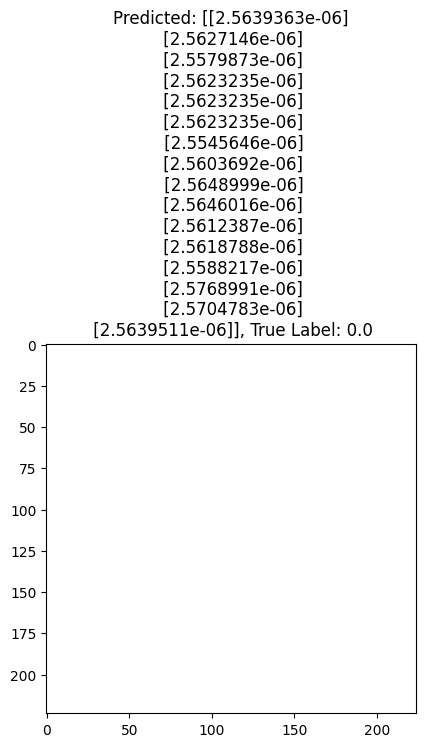

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [58.0..255.0].


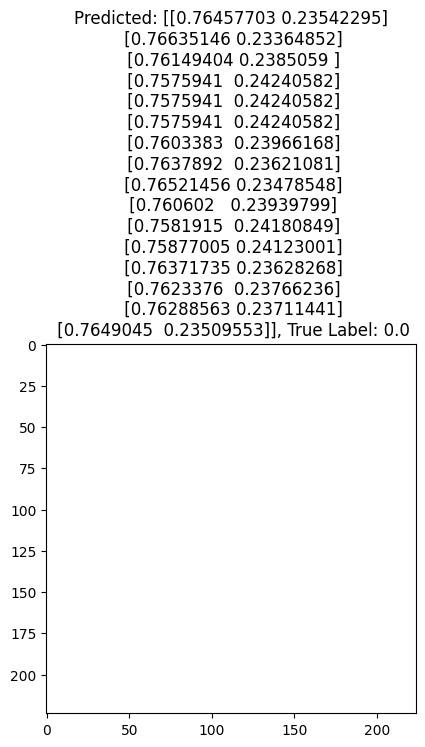

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


IndexError: list index out of range

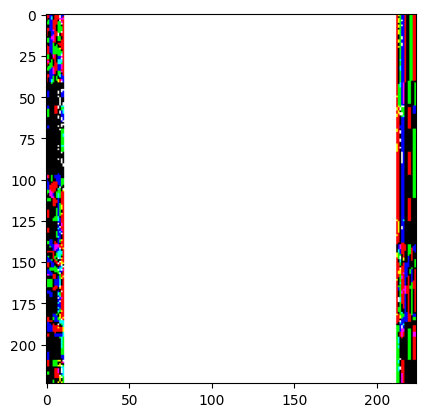

In [67]:
import matplotlib.pyplot as plt

# Generate a batch of test images and labels
images, labels = next(test_generator)

# Predict on this batch
predictions = model.predict(images)

# Display some images with predictions
for i in range(5):  # Display 5 images
    plt.imshow(images[i])
    plt.title(f'Predicted: {predictions[i]}, True Label: {labels[i]}')
    plt.show()


In [72]:
import tensorflow_model_optimization as tfmot
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB3
import tensorflow as tf

# Define your model architecture
def build_model_with_pruning(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # EfficientNet Feature Extraction
    base_model = EfficientNetB3(include_top=False, input_shape=input_shape, weights='imagenet')
    x = base_model(inputs, training=False)
    
    # Apply pruning to the convolutional block
    x = tfmot.sparsity.keras.prune_low_magnitude(layers.Conv2D(32, (3, 3), activation='relu'))(x)
    
    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)
    
    # Pruned LSTM for Temporal Analysis
    x = tf.expand_dims(x, axis=1)  # Expand dims for LSTM input
    x = tfmot.sparsity.keras.prune_low_magnitude(
        layers.Bidirectional(layers.LSTM(64, return_sequences=True))
    )(x)
    
    # Self-Attention Mechanism
    attention = layers.Attention()([x, x])
    x = layers.GlobalAveragePooling1D()(attention)
    
    # Dropout for Regularization
    x = layers.Dropout(0.5)(x)
    
    # Final Classification Layers
    domain_pred = tfmot.sparsity.keras.prune_low_magnitude(
        layers.Dense(10, activation='softmax', name='domain_output')
    )(x)
    spoof_pred = tfmot.sparsity.keras.prune_low_magnitude(
        layers.Dense(1, activation='sigmoid', name='spoof_output')
    )(x)
    
    model = models.Model(inputs=inputs, outputs=[spoof_pred, domain_pred])
    return model

# Build the pruned model
input_shape = (224, 224, 3)
model = build_model_with_pruning(input_shape)

# Define a pruning schedule
pruning_schedule = tfmot.sparsity.keras.PolynomialDecay(
    initial_sparsity=0.0, final_sparsity=0.5, begin_step=2000, end_step=10000
)

# Apply pruning to the entire model
pruned_model = tfmot.sparsity.keras.prune_low_magnitude(model, pruning_schedule=pruning_schedule)

# Compile the pruned model
pruned_model.compile(
    optimizer='adam',
    loss={
        'spoof_output': 'binary_crossentropy', 
        'domain_output': 'binary_crossentropy'
    },
    metrics={
        'spoof_output': 'accuracy', 
        'domain_output': 'accuracy'
    }
)

# Pruning callbacks
callbacks = [tfmot.sparsity.keras.UpdatePruningStep(), tfmot.sparsity.keras.PruningSummaries(log_dir='.')]
    
# Fine-tune the pruned model
pruned_model.fit(
    x_train, 
    [y_train, y_train],  # Assuming y_train works for both outputs; adapt as needed
    epochs=10, 
    validation_split=0.1, 
    callbacks=callbacks
)

# Evaluate the pruned model
loss, spoof_accuracy, domain_accuracy = pruned_model.evaluate(x_test, [y_test, y_test])
print(f'Test Loss: {loss}')
print(f'Test Spoof Accuracy: {spoof_accuracy}')
print(f'Test Domain Accuracy: {domain_accuracy}')


ValueError: `prune_low_magnitude` can only prune an object of the following types: keras.models.Sequential, keras functional model, keras.layers.Layer, list of keras.layers.Layer. You passed an object of type: Conv2D.

In [ ]:
# Strip the pruning wrappers
final_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

# Save the model
final_model.save('pruned_model.h5')


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)

# Enable full integer quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_model = converter.convert()

# Save the quantized model
with open('quantized_model.tflite', 'wb') as f:
    f.write(tflite_model)
